# 2 Layer Neural Network

## Imports

In [2]:
import os
import pandas as pd

## Import data and create .csv

In [4]:
# Directory to MRI Images
base_dir = '/Users/benrandoing/Downloads/archive/AugmentedAlzheimerDataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('dataset.csv'):
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('dataset.csv', index=False)

## Data Loading and Pre-Processing

In [15]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import torch.optim


class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224 X 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load the entire dataset
dataset = CustomDataset(csv_file='dataset.csv', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
print(f'Training Samples: {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 23788
Validation Samples: 5097
Test Samples: 5099


In [7]:
print(train_dataset)

In [8]:
import matplotlib.pyplot as plt
#plt.plot(train_dataset[0][0])
#plt.show()

## Pytorch Logistic Regression Model

In [9]:
class FiveLayerNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(FiveLayerNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = torch.nn.Linear(hidden_dim4, output_dim)

    def forward(self, x):
        #x = x.view(-1, 224 * 224 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

input_dim = 224 * 224 * 3  # Assuming the images are RGB
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
hidden_dim4 = 64
output_dim = 4  # Four classes

#model = FiveLayerNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.fc = torch.nn.Linear(model.fc.in_features, output_dim)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/benrandoing/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


## Hyperparameters

In [13]:
learning_rate = 0.001
num_epochs = 20
batch_size = 64

## DataLoaders

In [14]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Loss and Optimizer

In [17]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Training Loop

In [18]:
# DO NOT RUN IF LOADING WEIGHTS

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    i = 0
    for inputs, labels in train_loader:
        i = i + 1
        print("Training continues..", total_loss, "current i = ", i)    
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    #lr decay
    #lr_scheduler.step()

    print(f"Iteration {epoch} - Loss = {total_loss / len(train_loader)}")

Training continues.. 0.0 current i =  1


KeyboardInterrupt: 

## Load Model Weights

In [19]:
model.load_state_dict(torch.load('resnet18_more_epochs_adam_model_weights.pth'))

<All keys matched successfully>

## Evaluation

In [23]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        print(i)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f"Validation Accuracy: {validation_accuracy}%")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
Validation Accuracy: 92.70158917010006%


## Test

In [10]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 90.68444793096685%


In [11]:
import torch
torch.save(model.state_dict(), 'resnet18_more_epochs_adam_model_weights.pth')

### Saliency Plots

In [82]:
def show_saliency():
    """
    Compute a class saliency map for a single DL batch using the model for images X and labels y command and parameters.
    """
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        model.eval()

        for name, param in model.named_parameters():
            print(name, param.size())

        # Set requires_grad=True for model parameters
        for param in model.parameters():
            param.requires_grad = True

        images.requires_grad_()
        outputs_saliency = model(images)

        score, predicted = torch.max(outputs_saliency, 1)
        print(score[-1].requires_grad)

        model.zero_grad()

        score = score.sum()  # Ensure score is a scalar for backward()

        score.backward()

        saliency = images.grad.abs()
        saliency = saliency.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array
        images = images.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array


#         N = images.shape[0]
        N = 5
        for i in range(N):
            plt.subplot(2, N, i + 1)
            plt.imshow(images[i].squeeze()[0], cmap='gray')
            plt.axis('off')
            plt.subplot(2, N, N + i + 1)
            plt.imshow(saliency[i].squeeze()[0], cmap=plt.cm.hot)
            plt.axis('off')
            plt.gcf().set_size_inches(12, 5)
        plt.savefig('saliencybw.png')
        plt.show()

        return

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

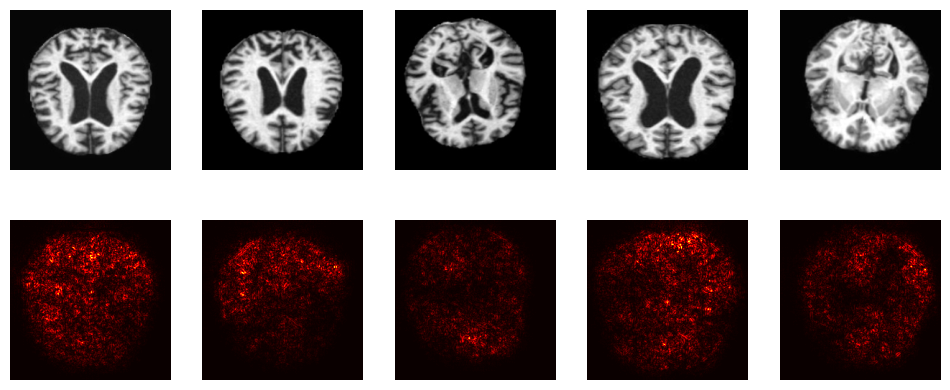

In [83]:
show_saliency()